In [1]:
%matplotlib inline
from typing import List

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ssg
import tensorly as tl
from scipy.fftpack import rfft, irfft, dct, idct
from tensorly.decomposition import parafac, tucker
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from statsmodels.tsa.seasonal import STL
from scipy.stats import linregress
import warnings
import statsmodels.api as sm
import pandas as pd
from scipy import interpolate

In [2]:
# introduce some utility functions
def repeat(ts: np.ndarray, times: int) -> np.ndarray:
    assert ts.ndim == 1
    out = np.array(ts)
    for _ in range(times - 1):
        out = np.r_[out, ts]
    return out

def fold(X: np.ndarray, n_p: int):
    """fold first mode into n_p tubes"""
    newshape = [-1, n_p] + list(X.shape[1:])
    return np.reshape(X, newshape)

def multifold(X: np.ndarray, n_ps: List[int]):
    for n_p in n_ps:
        X = fold(X, n_p)
    return X

def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.sqrt(
        np.nanmean(np.square(y_true - y_pred))
    )

In [3]:
def dct_dft_errors(data, max_params, param_sweep_scale="linear", no_params=1000):
    # RMSEs with DCT
    param_sweep = get_param_sweep(max_params, param_sweep_scale, no_params)
    dct_errors = [
        rmse(data, dct_reconstruct(data, p))
        for p in param_sweep
    ]

    # RMSEs with DFT
    dft_errors = [
        rmse(data, dft_reconstruct(data, p))
        for p in param_sweep
    ]
    return dct_errors, dft_errors, param_sweep

def dct_reconstruct(data: np.ndarray, n: int):
    z = dct(data)  # take the DCT

    # get the frequencies with most magnitude
    top_n = np.argsort(np.abs(z))[-n:]
    
    mask = np.zeros(len(z), dtype=bool)
    mask[top_n] = True

    # zero out the other frequencies
    z_masked = np.array(z)
    z_masked[~mask] = 0 

    # reconstruct
    return dct(z_masked, type=3) / len(z) / 2

def dft_reconstruct(data: np.ndarray, n: int):
    z = rfft(data)  # take the DCT

    # get the frequencies with most magnitude
    top_n = np.argsort(np.abs(z))[-n:]
    
    mask = np.zeros(len(z), dtype=bool)
    mask[top_n] = True

    # zero out the other frequencies
    z_masked = np.array(z)
    z_masked[~mask] = 0 

    # reconstruct
    return irfft(z_masked)

def tensor_errors(data, folds, ranks, decomposition_type="parafac"):
    # with tensors
    tensor_results = []
    for rank in ranks:
        _ = print(rank) if rank % 3 == 0 else None
        data_approx, npars = tensor_reconstruction(data,folds, rank, decomposition_type=decomposition_type)
        tensor_results.append(
            [rmse(data, data_approx), npars]
        )
    ten_errors, ten_params = zip(*tensor_results)
    return ten_errors, ten_params


In [4]:
# melih utility functions
def tensor_errors_test(data, test_data, folds, ranks, decomposition_type="parafac"):
    # with tensors
    tensor_results = []
    for rank in ranks:
        _ = print(rank) if (rank + 1) % 2 == 0 else None
        data_approx, npars = tensor_reconstruction(data, folds, rank,decomposition_type=decomposition_type)
        # calculate the training RMSE (we will change data approx below)
        rmse_train = rmse(data, data_approx)
        # take means of the tensor in the trivial direction
        # mean_trivial_direction = data_approx.mean(0)[np.newaxis, ...]
        # broadcast the mean to each slice in the trivial direction
        # for i in range(data_approx.shape[0]):
        #    data_approx[i, ...] = mean_trivial_direction
        tensor_results.append(
            [rmse_train, rmse(test_data, data_approx), npars]
        )
    ten_errors, test_errors, ten_params = zip(*tensor_results)
    return ten_errors, test_errors, ten_params

def get_param_sweep(max_params, param_sweep_scale, no_params):
    if param_sweep_scale == "linear":
        return np.floor(np.linspace(1, max_params, no_params)).astype(int)
    elif param_sweep_scale == "log":
        return np.unique(np.floor(np.logspace(0, np.log10(max_params), no_params))).astype(int)
    else:
        raise Exception("Param sweep scale not defined")

def dct_dft_errors_test(data, test_data, max_params, param_sweep_scale, no_params):
    dct_errors, dft_errors, param_sweep = dct_dft_errors(data=data, max_params=max_params, param_sweep_scale=param_sweep_scale, no_params=no_params)
    dct_test_errors = [
        rmse(test_data, dct_reconstruct(data, p))
        for p in param_sweep
    ]
    dft_test_errors = [
        rmse(test_data, dft_reconstruct(data, p))
        for p in param_sweep
    ]
    return dct_errors, dct_test_errors, dft_errors, dft_test_errors, param_sweep

def plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, folds, td_params=None, td_errors=None):
    f, ax = plt.subplots(figsize=(8, 6))
    ax.plot(param_sweep, dct_errors, 'b.-', label="DCT")
    ax.plot(param_sweep, dft_errors, 'g.-', label="DFT")
    ax.plot(ten_params, ten_errors, 'r.-', label="CP")
    if td_params is not None:
        ax.plot(td_params, td_errors, 'm.-', label="Tucker")
    ax.axvline(np.product(folds), color='grey', linestyle='--', label='$\dim \, \mathbf{s}$')
    ax.set(xlabel="# Parameters (logarithmic)", ylabel="RMSE")
    ax.legend()
    ax.semilogx();
    
def get_plot_data(idx, train_datas, test_datas, freq, plot=True):
    data = pd.concat((to_pandas(train_datas[idx]), to_pandas(test_datas[idx])))
    data.index = pd.date_range(start=data.index[0], freq=freq, periods=len(data))
    if plot:
        data.plot();
    return data

def get_gluonts_dataset(dataset_name):
    dataset = get_dataset(dataset_name, regenerate=False)
    train_datas = list(iter(dataset.train))
    test_datas = list(iter(dataset.test))
    lens = [len(d["target"]) for d in train_datas]
    freqs = [d["start"].freqstr for d in train_datas]
    print(pd.Series(lens).value_counts())
    print(pd.Series(freqs).value_counts())
    del dataset
    return train_datas, test_datas, lens, freqs

def tc_decompose(df, w, df_train=None):
    assert type(df) == pd.core.series.Series
    assert type(w) == int
    assert w > 1
    if w / len(df) > .10:
        print("Too many null values, using linear first order polynomial for detrending.")
        ma = df.copy()
        if df_train is None:
            m = linregress(range(len(df.values)), df.values)
            ma[:] = m.intercept + m.slope * np.arange(len(df.values))
        else:
            print("Using training data for linear regression, assuming continuity.")
            m = linregress(range(len(df_train.values)), df_train.values)
            ma[:] = m.intercept + m.slope *  (len(df_train) + np.arange(len(df.values)))
    else:
        if w % 2 == 0:
            lower_cumsum = df.cumsum().shift((w//2))
            lower_cumsum.iloc[w//2-1] = 0.
            ma_w = (df.cumsum().shift(-(w//2)) - lower_cumsum)/w
            lower_cumsum = ma_w.cumsum().shift(2)
            lower_cumsum.iloc[w//2] = 0.
            ma = (ma_w.cumsum() - lower_cumsum)/2
        elif w % 2 == 1:
            lower_cumsum = df.cumsum().shift((w//2 + 1))
            lower_cumsum.iloc[w//2] = 0.
            ma = (df.cumsum().shift(-(w//2)) - lower_cumsum)/w
        f = interpolate.interp1d(ma.reset_index(drop=True).dropna().index, ma.dropna().values, fill_value='extrapolate')
        ma[:] = f(range(len(ma)))
    return ma

def remove_ma(data, w, df_train=None):
    return data - tc_decompose(data, w, df_train=df_train)

def plot_tc_decomposition(data, ma_folds, df_train=None):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ma = tc_decompose(data, int(np.prod(ma_folds)), df_train=df_train)
        fig, axes = plt.subplots(3,1, sharex=True, sharey=True, figsize=(10,4))
        data.plot(ax=axes[0])
        ma.plot(ax=axes[1])
        (data - ma).plot(ax=axes[2])
        
def extend_test_data(data, test_data, freq):
    temp = pd.Series(index=pd.date_range(test_data.index[0], test_data.index[0] + (data.index[-1] - data.index[0]), freq=freq))
    temp.loc[test_data.index] = test_data.values
    print("You have extended your test data using null values at a frequency of: {}".format(freq))
    return temp

# tensor reconstruction
def tensor_reconstruction(data: np.ndarray, folds: List[int], rank: int, decomposition_type: object="parafac"):
    tensor = multifold(data, folds)
    if decomposition_type=="parafac":
        fac = parafac(tensor, rank=rank, n_iter_max=10000, tol=1.0e-15, linesearch=True)
        return tl.cp_to_tensor(fac).ravel(), np.sum([f.size for f in fac[1]][1:])
    elif decomposition_type=="tucker":
        if (type(rank) == int) or (type(rank) == float):
            rank = int(rank)
            rank = [rank for i in range(len(data.shape))]
        ranks = np.minimum(tensor.shape, rank)
        ranks[0] = 1
        core, factors = tucker(tensor, ranks=ranks, n_iter_max=10000, tol=1.0e-15)
        return tl.tucker_to_tensor((core, factors)).ravel(), np.sum([ranks[i] * tensor.shape[i] for i in range(1, len(tensor.shape))]) + np.prod(ranks[1:])

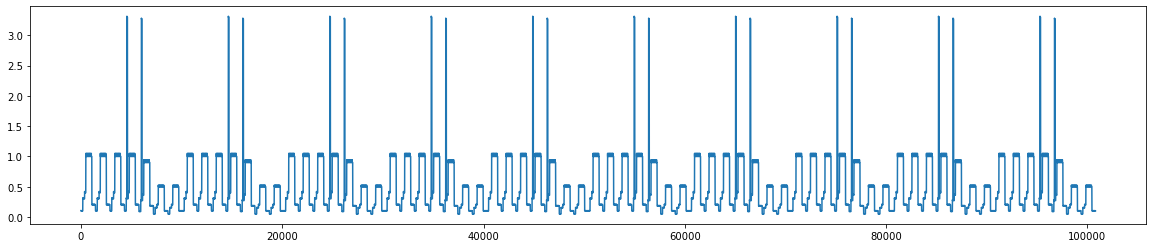

In [5]:
# generate data
w1 = np.array([1, 1, 1, 1, 0.9, 0.5, 0.5])
h1 = np.array([0.1, 0.1, 0.1, 0.3, 0.3, 0.3, 0.4, 0.4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, .2, .2, .2, .2, .2, .2])
m1 = np.ones(60)
m1[:10] = 1.05

w2 = np.array([0, 0, 0, 1, 1, 0, 0])
h2 = np.zeros(24)
m2 = np.ones(60)
h2[4] = 3

plt.subplots(figsize=(20, 4))

Z = np.outer(np.outer(w1, h1), m1)
Z += np.outer(np.outer(w2, h2), m2)

ts = Z.ravel()

plt.plot(repeat(ts, 10))

In [6]:
data = repeat(ts, 10)
data += np.random.rand(*data.shape) * 1e-1

### TODOs

- Add noise to this time series
- Forecast this time series with R forecast. 
- Approximate this time series via DFT. 

### DCT reconstruction

In this section, we look at the quality of reconstruction we take with 5, 10, 15 ... elements of the discrete cosine transform (DCT). For this, we take the highest magnitude elements one by one and zero out the rest of the frequencies and reconstruct the time-domain reconstruction via inverse DCT. 

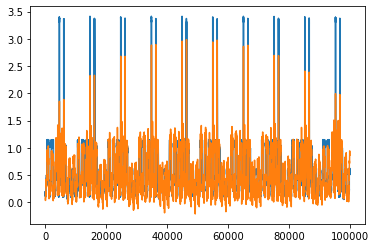

In [7]:
data_approx = dct_reconstruct(data, 100)
plt.plot(data[:100000])
plt.plot(data_approx[:100000])

### DFT Reconstruction

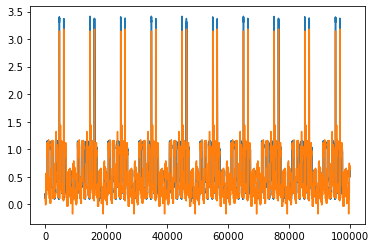

In [8]:
data_approx = dft_reconstruct(data, 100)
plt.plot(data[:100000])
plt.plot(data_approx[:100000])

### Tensor Reconstruction

In [9]:
data_approx, nr_params = tensor_reconstruction(data, [60, 24, 7], 2)

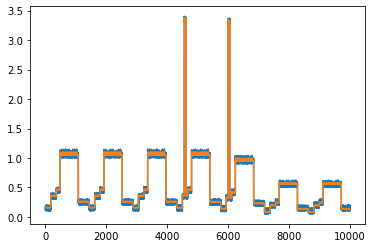

In [10]:
plt.plot(data[:10000])
plt.plot(data_approx[:10000])

### Comparing the two approaches with noisy data

In [11]:
data = repeat(ts, 10)
data += np.random.rand(*data.shape) * 1e-1

In [12]:
dct_errors, dft_errors, param_sweep = dct_dft_errors(data, 10000)

In [13]:
ten_errors, ten_params = tensor_errors(data, folds=[60, 24, 7], ranks=[1, 2, 3, 4])

3


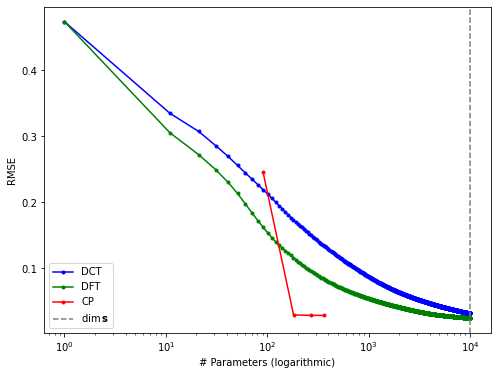

In [14]:
plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, [60, 24, 7])

# Real Data Applications

## Working with electricity consumption data

### Examining the data, basic preprocessing

In [16]:
df = pd.read_csv("data/household_power_consumption.csv", sep=";", usecols=['Date', 'Time', 'Global_active_power'], parse_dates={"Timestamp": ['Date', 'Time']}, infer_datetime_format=True, na_values="?", index_col="Timestamp")["Global_active_power"]
df.index.freq = "T"
df = df.loc["2007-01-01":] #trimming the last 15 days of december, and use only Global_active_power, which is almost perf. correlated with Global_intensity
df = df.fillna(df.loc["2007"].mean()) #interpolation see below

In [17]:
df.reset_index()["Timestamp"].diff().value_counts()

00:01:00    2053262
Name: Timestamp, dtype: int64

In [18]:
df.isnull().astype(int).groupby(df.notnull().astype(int).cumsum()).sum().value_counts().sort_index()

0    2053263
Name: Global_active_power, dtype: int64

In [19]:
df.isnull().sum()

0

In [20]:
df_hourly = df.resample("H").mean()
df_daily = df.resample("D").mean()

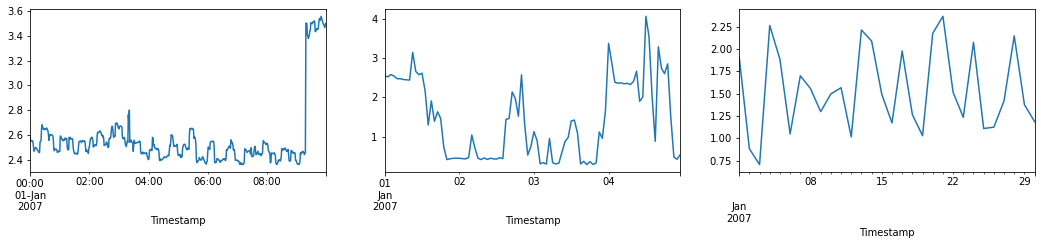

In [21]:
fig, axes = plt.subplots(1,3, figsize=(6*3, 3))
df.iloc[:600].plot(ax=axes[0]);
df_hourly.iloc[:96].plot(ax=axes[1]);
df_daily.iloc[:30].plot(ax=axes[2]);

## Working with hourly data

In [22]:
ts = df_hourly
freq = "H"
folds = [24,7,52]

extra = len(ts) % np.prod(folds)
test_data = ts.iloc[-extra:]
data = ts.iloc[:-extra]

Too many null values, using linear first order polynomial for detrending.


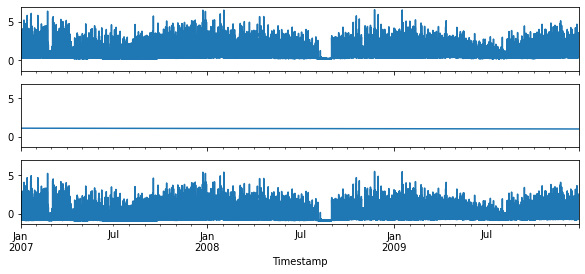

In [23]:
plot_tc_decomposition(data, folds)

Too many null values, using linear first order polynomial for detrending.
Using training data for linear regression, assuming continuity.


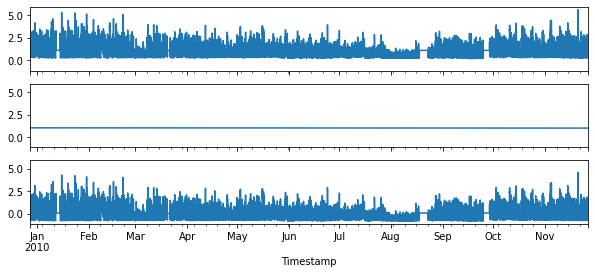

In [24]:
plot_tc_decomposition(test_data, folds, data)

In [25]:
test_data = remove_ma(test_data, int(np.prod(folds)), data)
data = remove_ma(data, int(np.prod(folds)))
test_data = extend_test_data(data, test_data, freq)

Too many null values, using linear first order polynomial for detrending.
Using training data for linear regression, assuming continuity.
Too many null values, using linear first order polynomial for detrending.
You have extended your test data using null values at a frequency of: H


In [26]:
dct_errors, dct_test_errors, dft_errors, dft_test_errors, param_sweep = dct_dft_errors_test(data, test_data, np.prod(folds), "log", 10)
ten_errors, ten_test_errors, ten_params = tensor_errors_test(data.values, test_data.values, folds=folds, ranks=list(range(1,6)))
tucker_errors, tucker_test_errors, tucker_params = tensor_errors_test(data.values, test_data.values, folds=folds, ranks=list(range(2,11)), decomposition_type="tucker")
print(ten_params)

/home/melih/anaconda3/lib/python3.7/site-packages/scipy/fft/_pocketfft/helper.py:97: FutureWarning: Series.flags is deprecated and will be removed in a future version
  copy = not x.flags['ALIGNED']


1
3
5
3
5
7
9
(83, 166, 249, 332, 415)


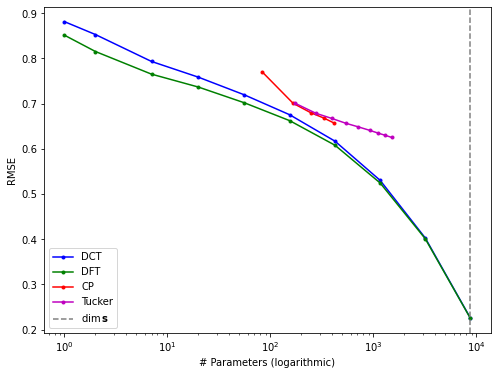

In [27]:
plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, folds, td_params=tucker_params, td_errors=tucker_errors)

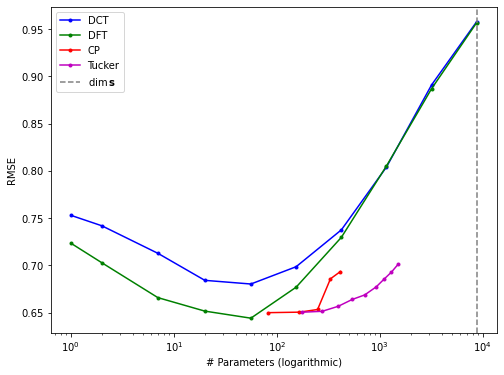

In [28]:
plot_comparison(dct_test_errors, dft_test_errors, ten_params, ten_test_errors, param_sweep, folds, td_params=tucker_params, td_errors=tucker_test_errors)

## Seasonal decompoisition

In [29]:
ts = df_hourly
freq = "H"
folds = [24,7,13,4]

extra = len(ts) % np.prod(folds)
test_data = ts.iloc[-extra:]
data = ts.iloc[:-extra]

Too many null values, using linear first order polynomial for detrending.


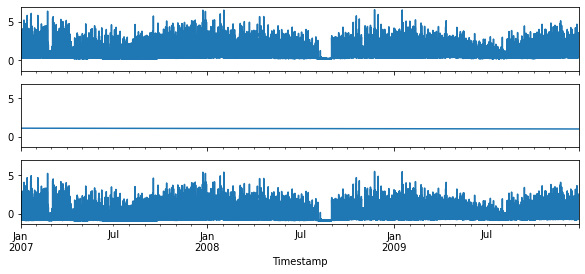

In [30]:
plot_tc_decomposition(data, folds)

Too many null values, using linear first order polynomial for detrending.
Using training data for linear regression, assuming continuity.


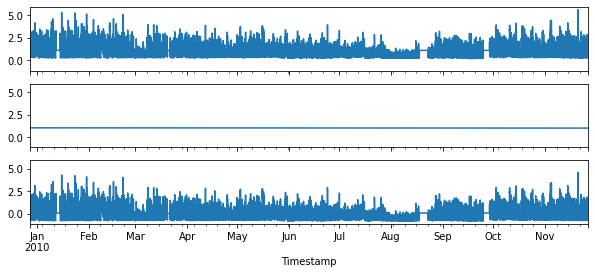

In [31]:
plot_tc_decomposition(test_data, folds, data)

In [32]:
#removing MA
#make sure you give the non detrended train data
test_data = remove_ma(test_data, int(np.prod(folds)), data)
data = remove_ma(data, int(np.prod(folds)))
#extending test data
test_data = extend_test_data(data, test_data, freq)

Too many null values, using linear first order polynomial for detrending.
Using training data for linear regression, assuming continuity.
Too many null values, using linear first order polynomial for detrending.
You have extended your test data using null values at a frequency of: H


In [33]:
dct_errors, dct_test_errors, dft_errors, dft_test_errors, param_sweep = dct_dft_errors_test(data, test_data, np.prod(folds), "log", 100)
ten_errors, ten_test_errors, ten_params = tensor_errors_test(data.values, test_data.values, folds=folds, ranks=list(range(1,6)))
tucker_errors, tucker_test_errors, tucker_params = tensor_errors_test(data.values, test_data.values, folds=folds, ranks=list(range(2,11)), decomposition_type="tucker")
print(ten_params)

/home/melih/anaconda3/lib/python3.7/site-packages/scipy/fft/_pocketfft/helper.py:97: FutureWarning: Series.flags is deprecated and will be removed in a future version
  copy = not x.flags['ALIGNED']


1
3
5
3
5
7
9
(48, 96, 144, 192, 240)


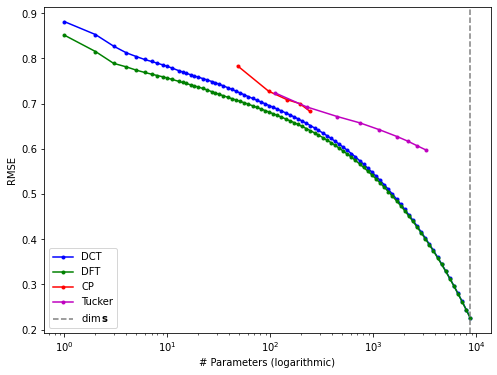

In [34]:
plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, folds, td_params=tucker_params, td_errors=tucker_errors)

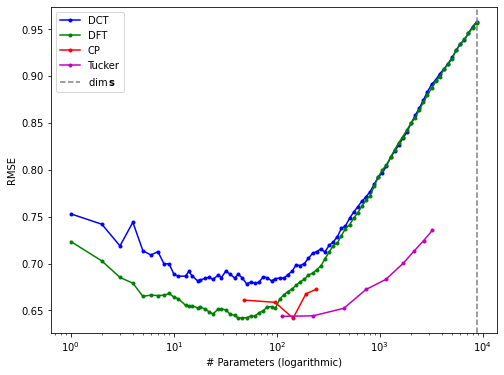

In [35]:
plot_comparison(dct_test_errors, dft_test_errors, ten_params, ten_test_errors, param_sweep, folds, td_params=tucker_params, td_errors=tucker_test_errors)

## Disregarding year information

In [95]:
ts = df_hourly
freq = "H"
folds = [24,7]

extra = len(ts) % np.prod(folds + [52]) #adding 52 here to get the last half year as test 
test_data = ts.iloc[-extra:]
data = ts.iloc[:-extra]

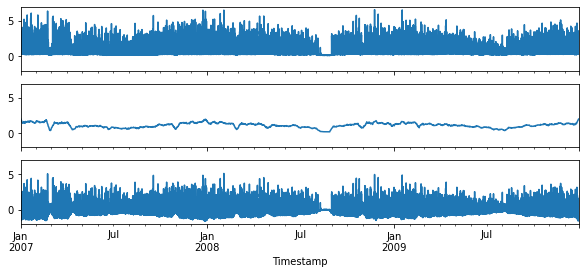

In [98]:
plot_tc_decomposition(data, folds)

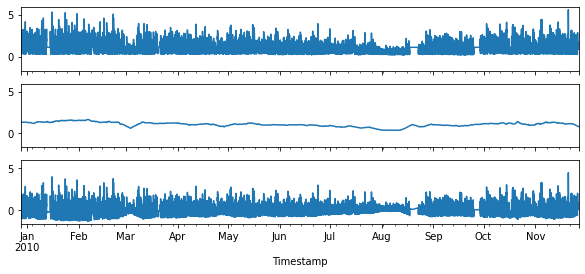

In [99]:
plot_tc_decomposition(test_data, folds, data)

In [100]:
#removing MA
#make sure you give the non detrended train data
test_data = remove_ma(test_data, int(np.prod(folds)), data)
data = remove_ma(data, int(np.prod(folds)))
#extending test data
test_data = extend_test_data(data, test_data, freq)

You have extended your test data using null values at a frequency of: H


In [101]:
dct_errors, dct_test_errors, dft_errors, dft_test_errors, param_sweep = dct_dft_errors_test(data, test_data, np.prod(folds), "log", 100)
ten_errors, ten_test_errors, ten_params = tensor_errors_test(data.values, test_data.values, folds=folds, ranks=list(range(1,6)))
tucker_errors, tucker_test_errors, tucker_params = tensor_errors_test(data.values, test_data.values, folds=folds, ranks=list(range(1,5)), decomposition_type="tucker")
print(ten_params)

/home/melih/anaconda3/lib/python3.7/site-packages/scipy/fft/_pocketfft/helper.py:97: FutureWarning: Series.flags is deprecated and will be removed in a future version
  copy = not x.flags['ALIGNED']


1
3
5
1
3
(31, 62, 93, 124, 155)


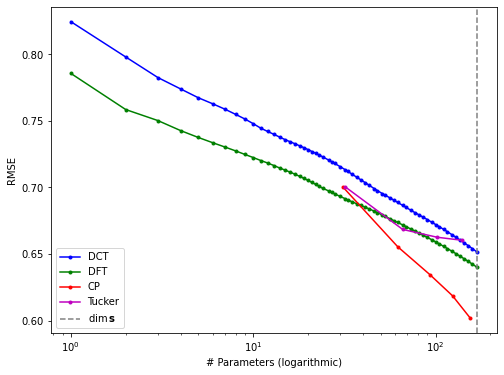

In [102]:
plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, folds, td_params=tucker_params, td_errors=tucker_errors)

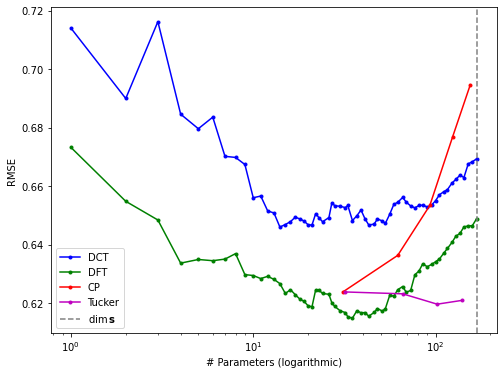

In [103]:
plot_comparison(dct_test_errors, dft_test_errors, ten_params, ten_test_errors, param_sweep, folds, td_params=tucker_params, td_errors=tucker_test_errors)

# GluonTS Datasets

### Electricity Dataset

In [51]:
train_datas, test_datas, lens, freqs = get_gluonts_dataset(dataset_name="electricity")

INFO:root:using dataset already processed in path /home/melih/.mxnet/gluon-ts/datasets/electricity.


21044    321
dtype: int64
H    321
dtype: int64


In [68]:
idx=1
ts = to_pandas(train_datas[idx])
freq = "H"
folds = [24,7,52]

extra = len(ts) % np.prod(folds)
test_data = ts.iloc[-extra:]
data = ts.iloc[:-extra]

Too many null values, using linear first order polynomial for detrending.


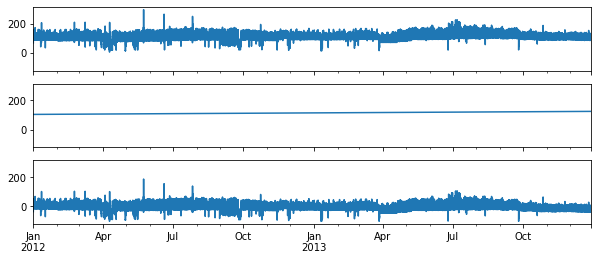

In [70]:
plot_tc_decomposition(data, folds)

Too many null values, using linear first order polynomial for detrending.
Using training data for linear regression, assuming continuity.


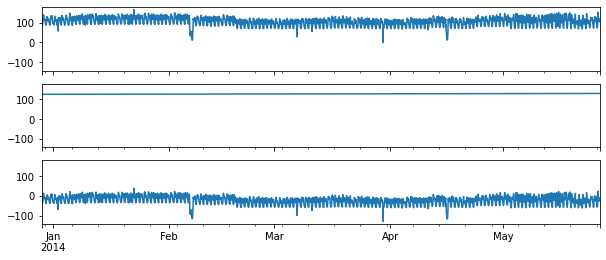

In [71]:
plot_tc_decomposition(test_data, folds, data)

In [72]:
#removing MA
#make sure you give the non detrended train data
test_data = remove_ma(test_data, int(np.prod(folds)), data)
data = remove_ma(data, int(np.prod(folds)))
#extending test data
test_data = extend_test_data(data, test_data, freq)

Too many null values, using linear first order polynomial for detrending.
Using training data for linear regression, assuming continuity.
Too many null values, using linear first order polynomial for detrending.
You have extended your test data using null values at a frequency of: H


In [73]:
dct_errors, dct_test_errors, dft_errors, dft_test_errors, param_sweep = dct_dft_errors_test(data, test_data, np.prod(folds), "log", 100)
ten_errors, ten_test_errors, ten_params = tensor_errors_test(data.values, test_data.values, folds=folds, ranks=list(range(1,6)))
tucker_errors, tucker_test_errors, tucker_params = tensor_errors_test(data.values, test_data.values, folds=folds, ranks=list(range(2,11)), decomposition_type="tucker")
print(ten_params)

/home/melih/anaconda3/lib/python3.7/site-packages/scipy/fft/_pocketfft/helper.py:97: FutureWarning: Series.flags is deprecated and will be removed in a future version
  copy = not x.flags['ALIGNED']


1
3
5
3
5
7
9
(83, 166, 249, 332, 415)


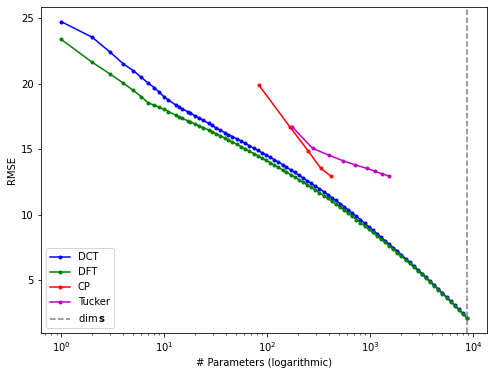

In [74]:
plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, folds, td_params=tucker_params, td_errors=tucker_errors)

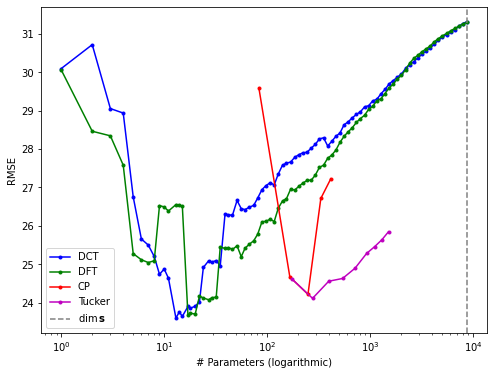

In [75]:
plot_comparison(dct_test_errors, dft_test_errors, ten_params, ten_test_errors, param_sweep, folds, td_params=tucker_params, td_errors=tucker_test_errors)

In [108]:
idx=1
ts = to_pandas(train_datas[idx])
freq = "H"
folds = [24,7]

extra = len(ts) % np.prod(folds + [52]) #adding 52 here to get the last half year as test 
test_data = ts.iloc[-extra:]
data = ts.iloc[:-extra]

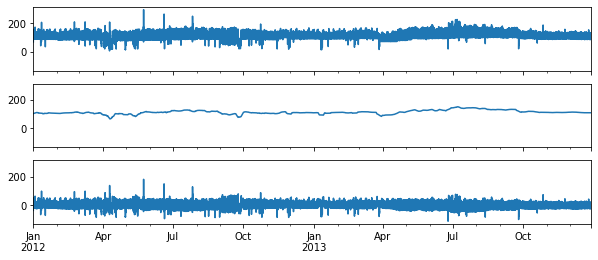

In [109]:
plot_tc_decomposition(data, folds)

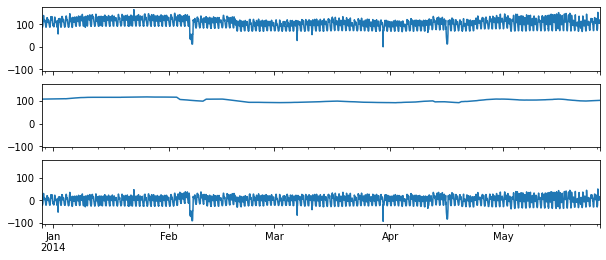

In [110]:
plot_tc_decomposition(test_data, folds, data)

In [111]:
#removing MA
#make sure you give the non detrended train data
test_data = remove_ma(test_data, int(np.prod(folds)), data)
data = remove_ma(data, int(np.prod(folds)))
#extending test data
test_data = extend_test_data(data, test_data, freq)

You have extended your test data using null values at a frequency of: H


In [115]:
dct_errors, dct_test_errors, dft_errors, dft_test_errors, param_sweep = dct_dft_errors_test(data, test_data, np.prod(folds), "log", 100)
ten_errors, ten_test_errors, ten_params = tensor_errors_test(data.values, test_data.values, folds=folds, ranks=list(range(1,6)))
tucker_errors, tucker_test_errors, tucker_params = tensor_errors_test(data.values, test_data.values, folds=folds, ranks=list(range(1,11)), decomposition_type="tucker")
print(ten_params)

/home/melih/anaconda3/lib/python3.7/site-packages/scipy/fft/_pocketfft/helper.py:97: FutureWarning: Series.flags is deprecated and will be removed in a future version
  copy = not x.flags['ALIGNED']


1
3
5
1
3
5
7
9
(31, 62, 93, 124, 155)


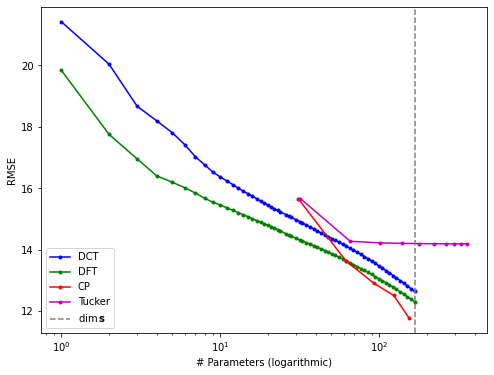

In [116]:
plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, folds, td_params=tucker_params, td_errors=tucker_errors)

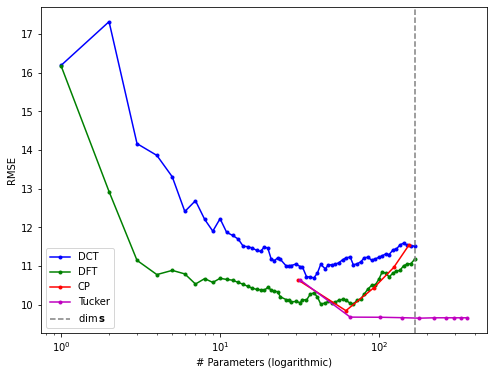

In [117]:
plot_comparison(dct_test_errors, dft_test_errors, ten_params, ten_test_errors, param_sweep, folds, td_params=tucker_params, td_errors=tucker_test_errors)

### Traffic Dataset

In [272]:
train_datas, test_datas, lens, freqs = get_gluonts_dataset(dataset_name="traffic")

INFO:root:using dataset already processed in path /home/melih/.mxnet/gluon-ts/datasets/traffic.


14036    862
dtype: int64
H    862
dtype: int64
